# Transformer

In [1]:
import math
import torch
import pandas as pd
from d2l import torch as d2l
from torch import nn

In [2]:
class PositionWiseFFN(nn.Module):
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs) -> None:
        super().__init__()
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)
    
    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

In [3]:
ffn = PositionWiseFFN(4,4,8)
ffn.eval()
ffn(torch.ones((2,3,4)))[0]

tensor([[ 0.0399, -0.1176, -0.4620, -0.2724,  0.5393,  0.5181,  0.1654,  0.4509],
        [ 0.0399, -0.1176, -0.4620, -0.2724,  0.5393,  0.5181,  0.1654,  0.4509],
        [ 0.0399, -0.1176, -0.4620, -0.2724,  0.5393,  0.5181,  0.1654,  0.4509]],
       grad_fn=<SelectBackward0>)

In [4]:
# LayerNorm和BatchNorm都是常见的归一化方法，但它们归一化的方式不同。
# LayerNorm对每个样本的特征进行归一化；BatchNorm对每个特征在整个batch维度上归一化。

ln = nn.LayerNorm(2)              # 初始化一个对最后一个维度大小为2进行归一化的LayerNorm
bn = nn.BatchNorm1d(2)            # 初始化一个Batch的特征维度为2的BatchNorm
X = torch.tensor([[1,2], [2,3]], dtype=torch.float32)  # 构造一个形状为(2,2)的小批量输入

print('layer norm:', ln(X))       # 对输入X按每行做归一化，均值为0，方差为1
print('batch norm:', bn(X))       # 对输入X按每列（特征维度）做归一化，均值为0，方差为1


layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>)
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


In [5]:
class AddNorm(nn.Module):
    def __init__(self, normalized_shape, dropout) -> None:
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)
    
    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

In [6]:
# 是的，[3,4]这两个维度会一起进行归一化，即nn.LayerNorm会对最后两个维度（size为3和4的维度）共同计算均值和方差。
add_norm = AddNorm([3,4], 0.5)   
add_norm.eval()
add_norm(torch.ones((2,3,4)), torch.ones((2,3,4))).shape

torch.Size([2, 3, 4])

In [7]:
def transpose_qkv(X, num_heads):
    """为了多注意力头的并行计算而变换形状"""
    # 输入X的形状:(batch_size，查询或者“键－值”对的个数，num_hiddens)
    # 输出X的形状:(batch_size，查询或者“键－值”对的个数，num_heads， num_hiddens/num_heads)
    X= X.reshape(X.shape[0], X.shape[1], num_heads, -1)
    # 输出X的形状:(batch_size，num_heads，查询或者“键－值”对的个数, num_hiddens/num_heads)
    X = X.permute(0, 2, 1, 3)
    # 最终输出的形状:(batch_size*num_heads,查询或者“键－值”对的个数, num_hiddens/num_heads)
    return X.reshape(-1, X.shape[2], X.shape[3])

#@save
def transpose_output(X, num_heads):
    """逆转transpose_qkv函数的操作"""
    X = X.reshape(-1, num_heads, X.shape[1], X.shape[2])
    X = X.permute(0, 2, 1, 3)
    return X.reshape(X.shape[0], X.shape[1], -1)

class MultiHeaderAttention(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens, num_heads, dropout, bias=False) -> None:
        super().__init__()
        self.num_heads = num_heads
        self.attention = d2l.DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)
    
    def forward(self, queries, keys, values, valid_lens):
        # queries，keys，values的形状:
        # (batch_size，查询或者“键－值”对的个数，num_hiddens)
        # valid_lens　的形状:
        # (batch_size，)或(batch_size，查询的个数)
        # 经过变换后，输出的queries，keys，values　的形状:
        # (batch_size*num_heads，查询或者“键－值”对的个数，num_hiddens/num_heads)
        queries = transpose_qkv(self.W_q(queries), self.num_heads)
        keys = transpose_qkv(self.W_k(keys), self.num_heads)
        values = transpose_qkv(self.W_v(values), self.num_heads)
        
        if valid_lens is not None:
            # 将 valid_lens 重复 num_heads 次，因为每个注意力头都需要独立的 valid_lens
            # 注意：参数名是 repeats 而不是 repeat
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0
            )
        
        output = self.attention(queries, keys, values, valid_lens)
        
        output_cat = transpose_output(output, num_heads=self.num_heads)
        return self.W_o(output_cat)

In [8]:
#@save
class EncoderBlock(nn.Module):
    """Transformer编码器块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        # 使用我们自己定义的 MultiHeaderAttention，而不是 d2l.MultiHeadAttention
        # 因为 d2l.MultiHeadAttention 的签名可能不同
        self.attention = MultiHeaderAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout,
            bias=use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(
            ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

In [9]:
X = torch.ones((2,100,24))
valid_lens = torch.tensor([3,2])
encoder_blk = EncoderBlock(24,24,24,24, [100, 24], 24,48,8,0.5)
encoder_blk.eval()
encoder_blk(X, valid_lens).shape

torch.Size([2, 100, 24])

In [10]:
#@save
class TransformerEncoder(d2l.Encoder):
    """Transformer编码器"""
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                EncoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, use_bias))

    def forward(self, X, valid_lens, *args):
        # 因为位置编码值在-1和1之间，
        # 因此嵌入值乘以嵌入维度的平方根进行缩放，
        # 然后再与位置编码相加。
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        return X

In [11]:
encoder = TransformerEncoder(200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
encoder.eval()
encoder(torch.ones((2,100), dtype=torch.long), valid_lens).shape

torch.Size([2, 100, 24])

In [12]:
class DecoderBlock(nn.Module):
    """
    Transformer 解码器块
    
    解码器块包含三个主要组件：
    1. 掩码自注意力（Masked Self-Attention）：解码器只能看到当前位置之前的信息
    2. 编码器-解码器注意力（Encoder-Decoder Attention）：关注编码器的输出
    3. 前馈神经网络（FFN）
    """
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i  # 当前解码器块的索引
        
        # attention1: 掩码自注意力（Masked Self-Attention）
        # 用于解码器内部的自注意力，需要掩码防止看到未来信息
        self.attention1 = MultiHeaderAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        
        # attention2: 编码器-解码器注意力（Encoder-Decoder Attention）
        # 解码器关注编码器的输出，不需要掩码（可以看所有编码器输出）
        self.attention2 = MultiHeaderAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        
        # 前馈神经网络
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens,
                                   num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)

    def forward(self, X, state):
        """
        前向传播
        
        参数:
            X: 解码器输入，形状 (batch_size, num_steps, num_hiddens)
            state: 状态元组，包含：
                - state[0]: enc_outputs，编码器输出
                - state[1]: enc_valid_lens，编码器有效长度
                - state[2]: 解码器各层的缓存（用于预测阶段）
        
        返回:
            output: 解码器输出
            state: 更新后的状态
        """
        enc_outputs, enc_valid_lens = state[0], state[1]
        
        # ========== 处理 key_values（用于自注意力） ==========
        # 
        # 关键理解：自注意力需要完整的序列作为 key 和 value
        # - query: 当前时间步（X）
        # - key/value: 需要包含所有历史时间步，才能让当前时间步关注历史
        #
        # 训练阶段：state[2][self.i] 初始化为 None
        #   - 所有时间步并行处理，X 已经包含所有时间步
        #   - X 形状: (batch_size, num_steps, num_hiddens)
        #   - key_values = X（直接使用，因为已经包含完整序列）
        #
        # 预测阶段：state[2][self.i] 包含之前所有时间步的输出
        #   - 逐个时间步解码，X 只包含当前时间步
        #   - X 形状: (batch_size, 1, num_hiddens) - 只有当前时间步！
        #   - state[2][self.i] 形状: (batch_size, t-1, num_hiddens) - 历史时间步
        #   - 必须拼接：key_values = [历史] + [当前]，才能让当前时间步关注历史
        if state[2][self.i] is None:
            # 训练阶段：X 已经包含所有时间步，直接使用
            key_values = X
        else:
            # 预测阶段：X 只有当前时间步，必须拼接历史才能实现自注意力
            # 如果不拼接，当前时间步只能关注自己，无法利用历史信息！
            key_values = torch.cat((state[2][self.i], X), axis=1)
        
        # 更新缓存（用于下一个时间步）
        state[2][self.i] = key_values
        
        # ========== 构造 dec_valid_lens（因果掩码） ==========
        if self.training:
            batch_size, num_steps, _ = X.shape
            
            # dec_valid_lens 的形状: (batch_size, num_steps)
            # 每一行是 [1, 2, 3, ..., num_steps]
            # 
            # 这确实是掩码！它实现了"因果掩码"（Causal Mask）：
            # - 第1个位置只能看到前1个位置（包括自己）
            # - 第2个位置只能看到前2个位置（包括自己）
            # - 第3个位置只能看到前3个位置（包括自己）
            # - ...
            # 
            # 例如 num_steps=5，dec_valid_lens = [[1,2,3,4,5], [1,2,3,4,5]]
            # 这告诉注意力机制：
            #   - 位置0：只能看位置0（有效长度=1）
            #   - 位置1：只能看位置0,1（有效长度=2）
            #   - 位置2：只能看位置0,1,2（有效长度=3）
            #   - 位置3：只能看位置0,1,2,3（有效长度=4）
            #   - 位置4：只能看位置0,1,2,3,4（有效长度=5）
            #
            # 这样就防止了"信息泄露"：解码器不能看到未来的信息
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            # 预测阶段：逐个时间步解码，不需要掩码
            # 因为每次只处理一个时间步，自然看不到未来
            dec_valid_lens = None

        # ========== 步骤1: 掩码自注意力（Masked Self-Attention） ==========
        # X: query，形状 (batch_size, num_steps, num_hiddens)
        # key_values: key 和 value，形状 (batch_size, num_steps, num_hiddens)
        # dec_valid_lens: 因果掩码，防止看到未来信息
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)  # 残差连接 + LayerNorm
        
        # ========== 步骤2: 编码器-解码器注意力（Encoder-Decoder Attention） ==========
        # Y: query（来自解码器），形状 (batch_size, num_steps, num_hiddens)
        # enc_outputs: key 和 value（来自编码器），形状 (batch_size, num_steps, num_hiddens)
        # enc_valid_lens: 编码器的有效长度（不是因果掩码，是序列长度掩码）
        # 
        # 注意：这里使用 enc_valid_lens，不是 dec_valid_lens！
        # - enc_valid_lens 表示编码器序列的实际长度（处理padding）
        # - 解码器可以关注编码器的所有有效位置
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)  # 残差连接 + LayerNorm
        
        # ========== 步骤3: 前馈神经网络 ==========
        return self.addnorm3(Z, self.ffn(Z)), state

In [13]:
decoder_blk = DecoderBlock(24, 24,24,24, [100, 24], 24,48,8,0.5,0)
decoder_blk.eval()
X = torch.ones((2,100,24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X,state)[0].shape

torch.Size([2, 100, 24])

In [14]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                DecoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range (2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # 解码器自注意力权重
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            # “编码器－解码器”自注意力权重
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

In [15]:
class EncoderDecoder(nn.Module):
    """
    编码器-解码器架构的基类
    
    这个类将编码器和解码器组合在一起，实现序列到序列的模型。
    前向传播时：
    1. 编码器处理输入序列，得到编码输出和隐藏状态
    2. 解码器使用编码器的输出初始化解码状态
    3. 解码器处理解码输入，返回预测结果和状态
    """
    def __init__(self, encoder, decoder, **kwargs):
        super(EncoderDecoder, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
    
    def forward(self, enc_X, dec_X, *args):
        """
        前向传播
        
        参数:
            enc_X: 编码器输入，形状 (batch_size, num_steps)
            dec_X: 解码器输入，形状 (batch_size, num_steps)
            *args: 额外的参数，例如 enc_valid_lens（编码器输入的有效长度）
        
        返回:
            dec_output: 解码器输出，形状 (batch_size, num_steps, vocab_size)
            dec_state: 解码器状态，用于后续时间步
        """
        # 编码器处理输入序列
        # enc_outputs 通常是 (outputs, hidden_state) 的元组
        enc_outputs = self.encoder(enc_X, *args)
        
        # 解码器使用编码器输出初始化解码状态
        # *args 可能包含 enc_valid_lens 等参数
        dec_state = self.decoder.init_state(enc_outputs, *args)
        
        # 解码器处理解码输入，返回输出和状态
        # 返回格式: (dec_output, dec_state)
        return self.decoder(dec_X, dec_state)

In [ ]:
from d2l.torch import MaskedSoftmaxCELoss


def train_seq2seq(net, data_iter, lr, num_epochs, tgt_vocab, device):
    """Train a model for sequence to sequence.

    Defined in :numref:`sec_utils`"""
    def xavier_init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
        if type(m) == nn.GRU:
            for param in m._flat_weights_names:
                if "weight" in param:
                    nn.init.xavier_uniform_(m._parameters[param])
    net.apply(xavier_init_weights)
    net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss = MaskedSoftmaxCELoss()
    net.train()
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs])
    for epoch in range(num_epochs):
        timer = d2l.Timer()
        metric = d2l.Accumulator(2)  # Sum of training loss, no. of tokens
        for batch in data_iter:
            optimizer.zero_grad()
            X, X_valid_len, Y, Y_valid_len = [x.to(device) for x in batch]
            bos = torch.tensor([tgt_vocab['<bos>']] * Y.shape[0],
                               device=device).reshape(-1, 1)
            dec_input = d2l.concat([bos, Y[:, :-1]], 1)  # Teacher forcing
            Y_hat, _ = net(X, dec_input, X_valid_len)
            l = loss(Y_hat, Y, Y_valid_len)
            l.sum().backward()  # Make the loss scalar for `backward`
            d2l.grad_clipping(net, 1)
            num_tokens = Y_valid_len.sum()
            optimizer.step()
            with torch.no_grad():
                metric.add(l.sum(), num_tokens)
        if (epoch + 1) % 10 == 0:
            animator.add(epoch + 1, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, {metric[1] / timer.stop():.1f} '
          f'tokens/sec on {str(device)}')

loss 0.032, 8830.6 tokens/sec on cpu


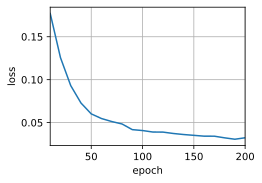

In [16]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
net = EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [17]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j’ai payé .,  bleu 0.000
he's calm . => il est calme .,  bleu 1.000
i'm home . => je suis chez moi .,  bleu 1.000


In [18]:
enc_attention_weights = torch.cat(net.encoder.attention_weights, 0).reshape((num_layers, num_heads,
    -1, num_steps))
enc_attention_weights.shape

torch.Size([2, 4, 10, 10])

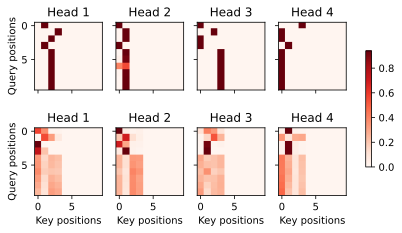

In [19]:
d2l.show_heatmaps(
    enc_attention_weights.cpu(), xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))

In [20]:
dec_attention_weights_2d = [head[0].tolist()
                            for step in dec_attention_weight_seq
                            for attn in step for blk in attn for head in blk]
dec_attention_weights_filled = torch.tensor(
    pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values)
dec_attention_weights = dec_attention_weights_filled.reshape((-1, 2, num_layers, num_heads, num_steps))
dec_self_attention_weights, dec_inter_attention_weights = \
    dec_attention_weights.permute(1, 2, 3, 0, 4)
dec_self_attention_weights.shape, dec_inter_attention_weights.shape

(torch.Size([2, 4, 6, 10]), torch.Size([2, 4, 6, 10]))

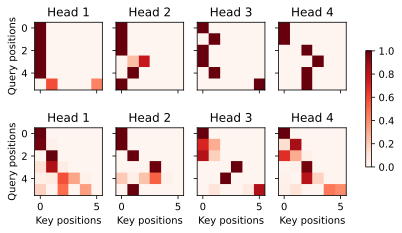

In [21]:
# Plusonetoincludethebeginning-of-sequencetoken
d2l.show_heatmaps(
    dec_self_attention_weights[:, :, :, :len(translation.split()) + 1],
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

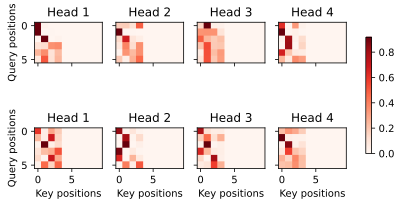

In [22]:
d2l.show_heatmaps(
    dec_inter_attention_weights, xlabel='Key positions',
    ylabel='Query positions', titles=['Head %d' % i for i in range(1, 5)],
    figsize=(7, 3.5))